In [2]:
import numpy as np
from matplotlib import pyplot as plt
import matplotlib
import brewer2mpl
from mitgcmdata import MITgcmmodel
from jmd95 import eos
import datetime

%matplotlib inline
plt.rcParams['image.origin'] = 'bottom'
plt.rcParams['figure.figsize'] = (16,8)


bmap = brewer2mpl.get_map('Set1', 'Qualitative', 6)
plt.rcParams['axes.color_cycle'] = bmap.mpl_colors


In [3]:
#ddir = '/glade/scratch/rpa/SOSE/run_matt'
#ddir = '/data/scratch/rpa/SOSE/run_matt'
ddir = '/data/scratch/rpa/SOSE/run_np240'

m = MITgcmmodel.ModelInstance(output_dir=ddir)


2160 320  42


/home/rpa/mitgcmdata/mitgcmdata/MITgcmmodel.py:75: RuntimeWarning: divide by zero encountered in reciprocal
  (self.rac * self.drf * self.hFacC)**-1, 0.)



    frequency(1) =  432000.0,
    fields(1,1) = 'SIarea  ','SIheff  ','SIhsnow ','SItflux ',
                 'SIatmQnt','SIempmr ','SIatmFW ','SIuheff ',
                 'SIvheff ','TFLUX   ','SFLUX   ','THETA   ',
                 'SALT    ','WTHMASS ','WSLTMASS','SIuice  ',
                 'SIvice  ','SIsnPrcp',
                 'SIdHbOCN','SIdSbOCN','SIdHbATO',
    levels(1,1) = 1,
    filename(1) = 'DiagIce-5day',


In [4]:
deltaT = 900
#diag_freq = 2629200. # monthly
#diag_prefix = 'DiagIce-monthly'

diag_freq = 432000 # 5-day
diag_prefix= 'DiagIce-5day'

diag_delta_iter = diag_freq/deltaT

ntimesteps = 210336
diag_iters = np.round(np.arange(diag_delta_iter, ntimesteps+1, diag_delta_iter)).astype('i4')
Nt = len(diag_iters)

diag_names = ['SIarea', 'SIheff', 'SIhsnow', 'SItflux', 'SIatmQnt', 'SIempmr',
             'SIatmFW', 'SIuheff', 'SIvheff', 'TFLUX', 'SFLUX', 'THETA', 'SALT',
             'WTHMASS','WSLTMASS','SIuice','SIvice','SIsnPrcp',
             'SIdHbOCN','SIdSbOCN','SIdHbATO']



In [5]:
lon = m.xc[0,:,:]
lat = m.yc[0,:,:]

In [6]:
def surface_transformation_rate(m, rho, rholevs, *args):
    """Calculate surface transformation rate given
        m: an MITgcmmodel.ModelInstance
        rho: a surface density field
        rholevs: density levels (to define bins)
        args: various components of the density flux
    """

    drho = np.diff(rholevs)
    Nbins = len(rholevs)-1
    
    # mask anything outside the range
    rho_m = np.ma.masked_greater_equal(
                np.ma.masked_less(rho, rholevs.min()), rholevs.max())
    mask = rho_m.mask
    
    rho_idx = np.digitize(rho_m.compressed(), rholevs)-1
    assert rho_idx.min()>=0
    assert rho_idx.max()<=Nbins
        
    # rho_idx==i means rholevs[i-1] <= rholevs < rholevs[i]
    
    
    res = []
    for a in args:
        dens_flux = np.ma.masked_array(a * m.rac, mask)
        res.append(
            np.bincount(rho_idx, weights=dens_flux.compressed(), minlength=Nbins)
            / drho
        )
    return np.array(res)
    
    

In [7]:
def average_field_in_rho(m, rho, rholevs, a, avg=True):
    """Calculate surface transformation rate given
        m: an MITgcmmodel.ModelInstance
        rho: a surface density field
        rholevs: density levels (to define bins)
        args: various components of the density flux
    """

    drho = np.diff(rholevs)
    Nbins = len(rholevs)-1
    
    # mask anything outside the range
    rho_m = np.ma.masked_greater_equal(
                np.ma.masked_less(rho, rholevs.min()), rholevs.max())
    mask = rho_m.mask
    
    rho_idx = np.digitize(rho_m.compressed(), rholevs)-1
    assert rho_idx.min()>=0
    assert rho_idx.max()<=Nbins
        
    # rho_idx==i means rholevs[i-1] <= rholevs < rholevs[i]
    
        
    rac_masked = np.ma.masked_array(m.rac, mask)
    area = np.bincount(rho_idx, weights=rac_masked.compressed(), minlength=Nbins)
    area_recip = np.where(area>0., area**-1, 0.)

    # area-weighted average
    res = np.bincount(rho_idx, weights=(a*rac_masked).compressed(), minlength=Nbins)
    if avg:
        res *= area_recip
    return res, area
    

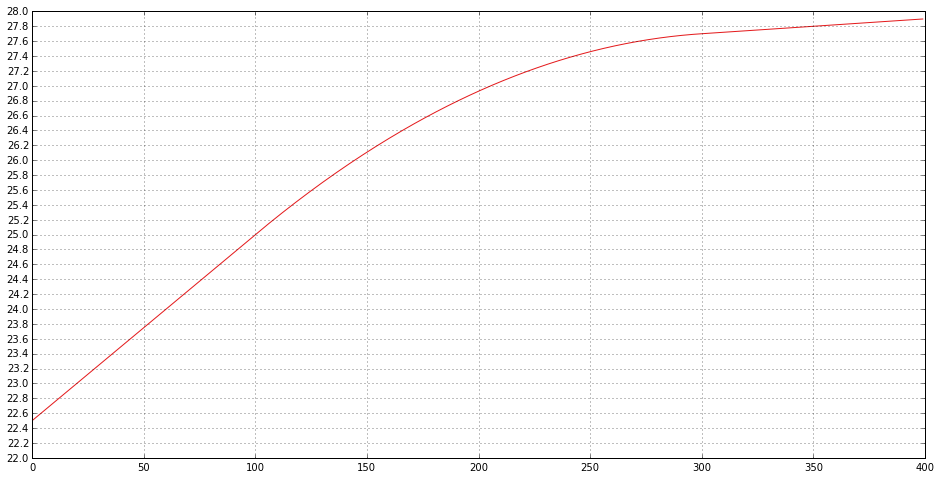

In [13]:
drho1 = 0.002
drho2 = 0.025
#drho3 = 0.025

rho0 = 1027.9

drho = np.hstack([
        drho1 * np.ones(100),
        np.linspace(drho1, drho2, 200),
        drho2 * np.ones(100),
#        np.linspace(drho2, drho3 ,100),
#        drho3 * np.ones(100),
])
rholevs = (rho0 - np.cumsum(drho))[::-1]
plt.plot(rholevs-1000, '-')
plt.yticks(np.arange(22,28.1,0.2))
plt.grid()

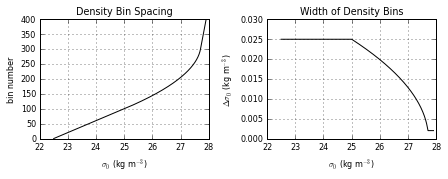

In [33]:
plt.rcParams['font.size'] = 8
plt.figure(figsize=(6.25,2.5))
plt.subplot(121)
plt.plot(rholevs-1000, np.arange(len(rholevs)),  'k')
plt.xlabel(r'$\sigma_0$ (kg m$^{-3}$)')
plt.ylabel('bin number')
plt.grid()
plt.title('Density Bin Spacing')
plt.subplot(122)
plt.plot(rholevs-1000, drho[::-1], 'k')
plt.xlabel(r'$\sigma_0$ (kg m$^{-3}$)')
plt.ylabel(r'$\Delta \sigma_0$ (kg m$^{-3}$)')
plt.grid()
plt.title('Width of Density Bins')
plt.tight_layout()
plt.savefig('../figures_ice_moc/density_bins.pdf')

In [9]:
salt_EvPrRn=0.
rUnit2mass=1.035E+03
HeatCapacity_Cp=3.994E+03

fluxfac_T = 1.0/(HeatCapacity_Cp*rUnit2mass)
fluxfac_S = 1.0/rUnit2mass

# gives m/year
scalefac = 24*60*60*365/1e3

#Nrho = 300
#rholevs = np.linspace(1022.,1028.0,Nrho+1)

Nrho = len(rholevs)-1

kg_fw_to_m = 1e-3
m_to_kg_fw = 1e3

fw_flux_types = ['IO_plus_AO', 'AI_plus_AO', 'AI', 'AO', 'IO', 'IO_brine', 'IO_melt']

fld_idx = dict()
for n, k in enumerate(fw_flux_types):
    fld_idx[k] = n


In [50]:
# density-weighted ice concentration
ice_conc_rho = np.zeros((Nt, Nrho), 'f8')
heff_rho = np.zeros((Nt, Nrho), 'f8')
outcrop_area = np.zeros((Nt, Nrho), 'f8')
for nmon, niter in enumerate(diag_iters):
    
    SIarea = m.rdmds(diag_prefix, niter, rec=0)
    heff = m.rdmds(diag_prefix, niter, rec=1)
    theta = m.rdmds(diag_prefix, niter, rec=11)
    salt = m.rdmds(diag_prefix, niter, rec=12)
    
    rho, drhodt, drhods = eos.state_surface(theta, salt)
    
    ice_conc_rho[nmon], outcrop_area[nmon] = average_field_in_rho(m, rho, rholevs, SIarea)
    heff_rho[nmon], outcrop_area[nmon] = average_field_in_rho(m, rho, rholevs, heff, avg=False)
    

In [12]:
transformation = np.zeros((Nt, len(fw_flux_types)+3, Nrho), 'f8')
fw_in_dens_coords = np.zeros((Nt, len(fw_flux_types), Nrho), 'f8')

for nmon, niter in enumerate(diag_iters):
    
    draw = m.rdmds(diag_prefix, niter)
    d = {}
    for n, dn in enumerate(diag_names):
        d[dn] = draw[n]
        
    rho, drhodt, drhods = eos.state_surface(d['THETA'], d['SALT'])

    # freshwater fluxes, evaporation positive
    fw_fluxes = {
      'IO_plus_AO': np.ma.masked_array(d['SIempmr'], m.mask[0]),
      'AI_plus_AO': -np.ma.masked_array(d['SIatmFW'], m.mask[0]),
# ------ not actually useful ----------
#       'SIdHbOCN': -m_to_kg_fw * np.ma.masked_array(data['SIdHbOCN'][season], m.mask[0]),
#       'SIdSbOCN': -m_to_kg_fw * np.ma.masked_array(data['SIdSbOCN'][season], m.mask[0]),
#       'SIdHbATO': -m_to_kg_fw * np.ma.masked_array(data['SIdSbOCN'][season], m.mask[0]),
      'SIsnPrcp':  -np.ma.masked_array(d['SIsnPrcp'], m.mask[0])
    }
    
    fw_fluxes['AI'] = fw_fluxes['SIsnPrcp']
    fw_fluxes['AO'] = fw_fluxes['AI_plus_AO'] - fw_fluxes['AI']
    fw_fluxes['IO'] = fw_fluxes['IO_plus_AO'] - fw_fluxes['AO']
    # brine rejection
    fw_fluxes['IO_brine'] = np.ma.masked_less(fw_fluxes['IO'].copy(), 0.)
    fw_fluxes['IO_melt'] = np.ma.masked_greater(fw_fluxes['IO'].copy(), 0.)
    
    # has the same units as SFLUX
    salt = d['SALT']
    
    dens_flux_S = [ drhods * fluxfac_S * fw_fluxes[k].filled(0.) * (salt - salt_EvPrRn)
                    for k in fw_flux_types ]

    dens_flux_S.append( drhods * d['WSLTMASS'] )
    
    fw_flux = [fw_fluxes[k].filled(0.) for k in fw_flux_types]
    
    tflux = np.ma.masked_array(d['TFLUX'], m.mask[0]) 
    dens_flux_T = [drhodt * fluxfac_T * tflux, ]
    
    dens_flux_T.append( drhodt * d['WTHMASS'])
    
    transformation[nmon] = surface_transformation_rate(
                        m, rho, rholevs,
                         *(dens_flux_T + dens_flux_S))
    
    fw_in_dens_coords[nmon] = surface_transformation_rate(
                        m, rho, rholevs, *fw_flux)

    

In [35]:
print transformation.shape
transformation_labels = (['heat_flux', 'heat_wthmass'] +
    ['salt_' + fwft for fwft in fw_flux_types] + ['salt_wsltmass'])
print transformation_labels
print len(transformation_labels)

(438, 10, 399)
['heat_flux', 'heat_wthmass', 'salt_IO_plus_AO', 'salt_AI_plus_AO', 'salt_AI', 'salt_AO', 'salt_IO', 'salt_IO_brine', 'salt_IO_melt', 'salt_wsltmass']
10


In [42]:
# just turn it all to an xray dataset
import xray
deltaTclock = 900
time = (np.datetime64('2005-01-01 00:00:00') + 
        np.array([np.timedelta64(deltaTclock) * i for i in diag_iters]))
sigma0 = rholevs[1:]-1000.
ds = xray.Dataset(coords={'sigma0': sigma0, 'time': time})

for n in range(len(transformation_labels)):
    ds[transformation_labels[n]] = xray.DataArray(transformation[:,n],
                        coords=[time, sigma0], dims=('time', 'sigma0'))

ds.to_netcdf('../data/wmt_surface.nc')

-c:5: DeprecationWarning: Implicitly casting between incompatible kinds. In a future numpy release, this will raise an error. Use casting="unsafe" if this is intentional.


In [55]:
ds_ice = xray.Dataset(coords={'sigma0': sigma0, 'time': time})
ds_ice['heff'] = xray.DataArray(heff_rho, 
                   coords=[time, sigma0], dims=('time', 'sigma0'))
ds_ice['concentration'] = xray.DataArray(ice_conc_rho, 
                   coords=[time, sigma0], dims=('time', 'sigma0'))
ds_ice['outcrop_area'] = xray.DataArray(outcrop_area, 
                   coords=[time, sigma0], dims=('time', 'sigma0'))
ds_ice.to_netcdf('../data/ice_in_rho_space.nc')
ds_ice

<xray.Dataset>
Dimensions:        (sigma0: 399, time: 438)
Coordinates:
  * sigma0         (sigma0) float64 22.53 22.55 22.58 22.6 22.63 22.65 22.68 ...
  * time           (time) datetime64[ns] 2005-01-06T05:00:00 ...
Data variables:
    heff           (time, sigma0) float64 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 ...
    concentration  (time, sigma0) float64 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 ...
    outcrop_area   (time, sigma0) float64 4.745e+08 2.369e+08 4.845e+08 ...

In [52]:
# load extra water mass transformation data
wmt_full = np.load('../data/wmt_upper_470m.npz')
labels_salt = ['surfflux', 'linfs', 'adv', 'hdiff', 'kpp', 'tot', 'vdiff']
labels_heat = ['surfflux', 'linfs', 'adv', 'kpp', 'vdiff', 'sw', 'tot', 'hdiff']
wmt_salt = wmt_full['wmt_salt'] 
wmt_heat = wmt_full['wmt_heat'] 
wmt_salt_mean = wmt_salt.mean(axis=0)
wmt_heat_mean = wmt_heat.mean(axis=0)


# Transformation Rates #

In [12]:
#transformation_run_matt = transformation.copy()

In [22]:
wmass_names = {'SAMW': 26.0, 'AAIW': 27.0, 'UCDW': 27.55, 'LCDW': 27.72, 'AABW': 27.82}
wmass_boundaries = [('SAMW', (26.0,27.0)), ('AAIW', (27.0,27.55)),
                    ('UCDW', (27.55,27.72)), ('LCDW', (27.72, 27.82)),
                    ('AABW', (27.82,29.))]

In [26]:
sig = rholevs[1:]-1000

wmass_idx = []

for wmass_name, wmass_lims in wmass_boundaries:
    idx = [np.argmin((sig - s)**2) for s in wmass_lims]
    wmass_idx.append(
        (wmass_name, idx)
    )
wmass_idx

[('SAMW', [143, 204]),
 ('AAIW', [204, 262]),
 ('UCDW', [262, 309]),
 ('LCDW', [309, 359]),
 ('AABW', [359, 398])]

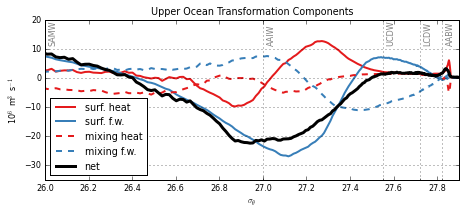

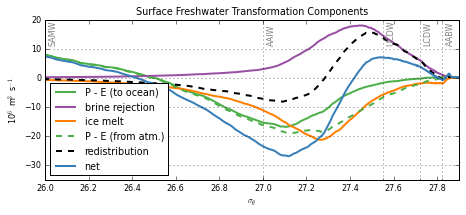

In [20]:
trans_mean = transformation.mean(axis=0)
#trans_mean = transformation_run_matt.mean(axis=0)

mcols = bmap.mpl_colors
plt.rcParams['legend.handlelength'] = 2.5
plt.rcParams['font.size'] = 8

fig = plt.figure(figsize=(6.5,3.0))
ax = fig.add_subplot(111)

idx_mean = np.r_[0,2]



ax.plot(rholevs[1:]-1000, trans_mean[idx_mean].T/1e6, linewidth=2)


# new stuff
ax.plot(rholevs[1:]-1000, (wmt_heat_mean[3]+wmt_heat_mean[4])/1e6,
         '--', color=mcols[0], linewidth=2)
ax.plot(rholevs[1:]-1000, (wmt_salt_mean[4]+wmt_salt_mean[6])/1e6,
         '--', color=mcols[1], linewidth=2)


ax.plot(rholevs[1:]-1000, (trans_mean[idx_mean].sum(axis=0)
                          + wmt_heat_mean[3] + wmt_heat_mean[4]
                          + wmt_salt_mean[4] + wmt_salt_mean[6])/1e6
         , 'k', linewidth=3)
ax.legend(['surf. heat', 'surf. f.w.', 'mixing heat', 'mixing f.w.', 'net'], loc='lower left')
ax.grid()
ax.set_title('Upper Ocean Transformation Components')
ax.set_xlabel(r'$\sigma_\theta$')
ax.set_ylabel(r'10$^6$ m$^3$ s$^{-1}$')

ax.set_xticks(np.arange(26,28.2,0.2), minor=False);
ax.set_xticks(wmass_names.values(), minor=True);

ax.xaxis.grid(False, which='major')
ax.xaxis.grid(True, which='minor')

for name, dens in wmass_names.iteritems():
    ax.text(dens+0.02, 11, name, color='0.5',
            ha='left', va='bottom', rotation='vertical')

ax.set_xlim([26,27.9])
ax.set_ylim([-35,20])
plt.tight_layout()
plt.savefig('../figures_ice_moc/transformation_sigma0_w_mixing.pdf')

# which fields to plot
fw_transformation = dict()
for ni, k in enumerate(fw_flux_types):
    fw_transformation[k] = trans_mean[ni+2]

fig = plt.figure(figsize=(6.5,3.0))
ax = fig.add_subplot(111)
colors = bmap.mpl_colors[2:]
for nc, k in enumerate(['AO', 'IO_brine', 'IO_melt']):
    tr = fw_transformation[k]
    plt.plot(rholevs[1:]-1000, tr/1e6, linewidth=2, color=colors[nc])
#redist = fw_transformation['IO'] - fw_transformation['AI']
ax.plot(rholevs[1:]-1000, fw_transformation['AI_plus_AO']/1e6, '--',
             linewidth=2, color=colors[0],)
redist = fw_transformation['IO'] - fw_transformation['AI']
ax.plot(rholevs[1:]-1000, redist/1e6, 'k--', linewidth=2)

ax.plot(rholevs[1:]-1000, trans_mean[2]/1e6, color=mcols[1], linewidth=2)
    
    
#plt.plot(rholevs[1:]-1000, trans_mean[1:].T/1e6, linewidth=2)
#plt.legend(['heat', 'fw', 'net'], loc='lower left')
#plt.legend(fw_flux_types, loc='lower left')
ax.legend(['P - E (to ocean)', 'brine rejection', 'ice melt',
            'P - E (from atm.)','redistribution', 'net'], loc='lower left')
ax.grid()
ax.set_title('Surface Freshwater Transformation Components')
ax.set_xlabel(r'$\sigma_\theta$')
ax.set_ylabel(r'10$^6$ m$^3$ s$^{-1}$')

ax.set_xticks(np.arange(26,28.2,0.2), minor=False);
ax.set_xticks(wmass_names.values(), minor=True);

ax.xaxis.grid(False, which='major')
ax.xaxis.grid(True, which='minor')

for name, dens in wmass_names.iteritems():
    ax.text(dens+0.02, 11, name, color='0.5',
            ha='left', va='bottom', rotation='vertical')

ax.set_xlim([26,27.9])
ax.set_ylim([-35,20])
plt.tight_layout()
plt.savefig('../figures_ice_moc/transformation_fw_sigma0.pdf')



#plt.savefig('../figures_ice_moc/transformation_5day_hires.pdf')

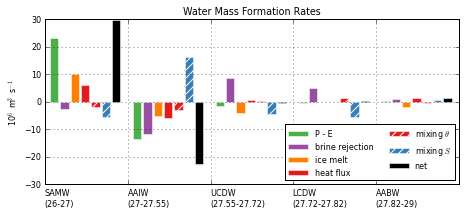

In [127]:

N=8.

def formation_bar(component, offset, color, ax, hatch=None):
    for n, (name, lims) in enumerate(wmass_idx):
        bars = plt.bar(n+offset+0.5/N, component[lims[0]] - component[lims[1]],
                       width=0.1, color=color, hatch=hatch, edgecolor='w', linewidth=0.5)
    return bars[0]


bars = []
fig = plt.figure(figsize=(6.5,3.0))
ax = fig.add_subplot(111)
colors = bmap.mpl_colors[2:]
for nc, k in enumerate(['AO', 'IO_brine', 'IO_melt']):
    tr = fw_transformation[k]
    bars.append(formation_bar(tr/1e6, nc/N, colors[nc], ax))
    
    
bars.append(formation_bar(trans_mean[idx_mean][0]/1e6, 3/N, mcols[0], ax))

bars.append(formation_bar((wmt_heat_mean[3]+wmt_heat_mean[4])/1e6, 4/N, mcols[0], ax, hatch='///'))
bars.append(formation_bar((wmt_salt_mean[4]+wmt_salt_mean[6])/1e6, 5/N, mcols[1], ax, hatch='///'))

bars.append(formation_bar((trans_mean[idx_mean].sum(axis=0)
                          + wmt_heat_mean[3] + wmt_heat_mean[4]
                          + wmt_salt_mean[4] + wmt_salt_mean[6])/1e6,
              6/N, 'k', ax))


#ax.spines['right'].set_visible(False)
#ax.spines['top'].set_visible(False)
#ax.spines['bottom'].set_visible(False) 
#ax.spines['bottom'].set_position(('data',0))

ax.set_xticklabels([])
#ax.yaxis.set_ticks_position('left')
#ax.xaxis.set_ticks_position('bottom')
ax.set_ylabel(r'10$^6$ m$^3$ s$^{-1}$')
ax.grid()
ax.legend(bars,
          ['P - E', 'brine rejection', 'ice melt','heat flux',r'mixing $\theta$','mixing $S$','net'],
         ncol=2, loc='lower right', fontsize=8)

ax.set_xticklabels(['%s\n(%g-%g)' % (w[0], w[1][0], w[1][1]) for w in wmass_boundaries], ha='left')
ax.set_title('Water Mass Formation Rates')

plt.tight_layout()
plt.savefig('../figures_ice_moc/formation_sigma0.pdf')


In [110]:
plt.legend()

[('SAMW', (26.0, 27.0)),
 ('AAIW', (27.0, 27.55)),
 ('UCDW', (27.55, 27.72)),
 ('LCDW', (27.72, 27.82)),
 ('AABW', (27.82, 29.0))]

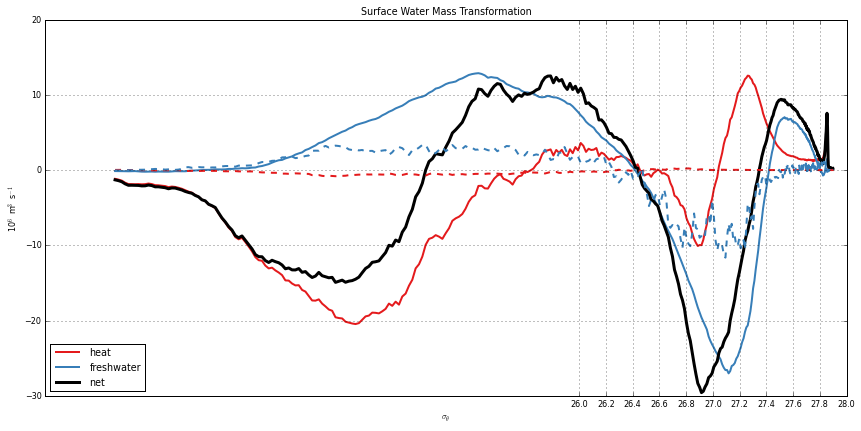

In [28]:
# with wthmass, wsltmass

#plt.figure(figsize=(6.5,3.0))
plt.figure(figsize=(12,6))

idx_mean = np.r_[0,2]

plt.plot(rholevs[1:]-1000, trans_mean[idx_mean].T/1e6, linewidth=2)
plt.plot(rholevs[1:]-1000, trans_mean[idx_mean].sum(axis=0)/1e6, 'k', linewidth=3)
plt.plot(rholevs[1:]-1000, trans_mean[1]/1e6, '--', linewidth=2, color=bmap.mpl_colors[0])
plt.plot(rholevs[1:]-1000, trans_mean[-1]/1e6, '--', linewidth=2, color=bmap.mpl_colors[1])

plt.legend(['heat', 'freshwater', 'net'], loc='lower left')
plt.grid()
plt.title('Surface Water Mass Transformation')
plt.xlabel(r'$\sigma_\theta$')
plt.ylabel(r'10$^6$ m$^3$ s$^{-1}$')
plt.xticks(np.arange(26,28.2,0.2));
#plt.xlim([26,27.9])
plt.ylim([-30,20])
plt.tight_layout()
#plt.savefig('../figures_ice_moc/transformation_5day_sigma0.pdf')

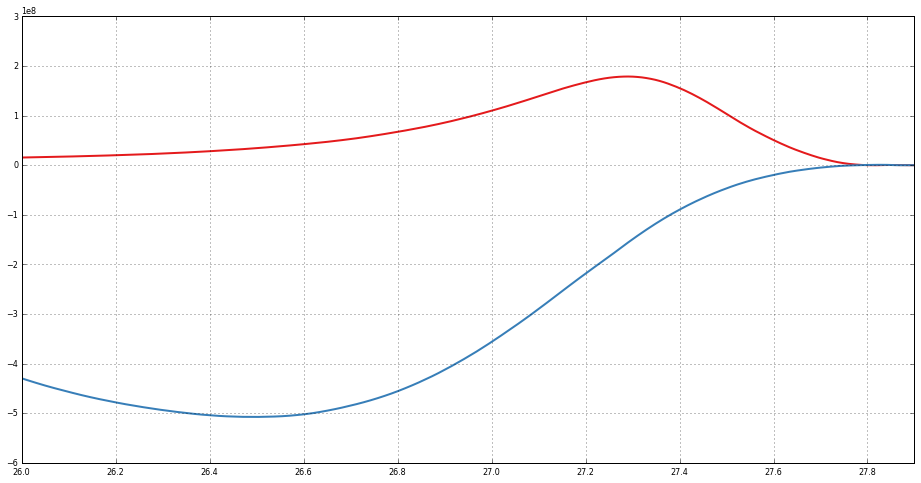

In [38]:
fw_mean = fw_in_dens_coords.mean(axis=0)

drho = np.diff(rholevs)
fw_ice_dens_flux = np.cumsum((drho * (
        fw_mean[fld_idx['IO']] - fw_mean[fld_idx['AI']]
         ))[::-1]
    )[::-1]

fw_atm_dens_flux = np.cumsum((drho * (
        fw_mean[fld_idx['AI_plus_AO']]
         ))[::-1]
    )[::-1]


# units kg / s
m3_per_kg = 1e-3

plt.plot(rholevs[1:]-1000, fw_ice_dens_flux, linewidth=2)
plt.plot(rholevs[1:]-1000, fw_atm_dens_flux, linewidth=2)
plt.xticks(np.arange(26,28.2,0.2));
plt.xlim([26,27.9])
plt.grid()


The two dashed lines sum to give the blue line.

# Temporal Variability #

In [43]:
T = np.array([datetime.datetime(2005,1,1) + datetime.timedelta(days=(n*5)) for n in range(Nt)])
rl = rholevs[1:]-1000

NameError: name 'wmt_salt' is not defined

/usr/local/anaconda/lib/python2.7/site-packages/matplotlib/text.py:52: UnicodeWarning: Unicode equal comparison failed to convert both arguments to Unicode - interpreting them as being unequal
  if rotation in ('horizontal', None):
/usr/local/anaconda/lib/python2.7/site-packages/matplotlib/text.py:54: UnicodeWarning: Unicode equal comparison failed to convert both arguments to Unicode - interpreting them as being unequal
  elif rotation == 'vertical':


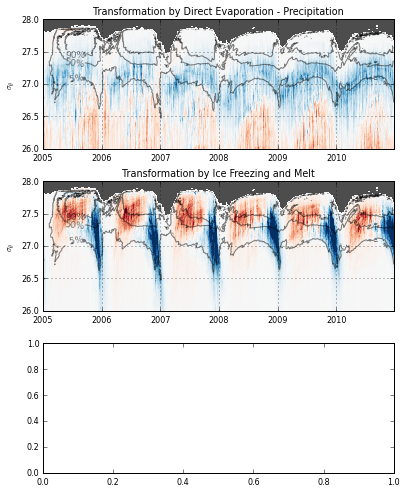

In [51]:
# which fields to plot
fw_transformation = dict()
for ni, k in enumerate(fw_flux_types):
    fw_transformation[k] = transformation[:,ni+2]

fig = plt.figure(figsize=(6.5,7.))

mask = (outcrop_area<1e9)

plt.subplots_adjust(left=0.1, bottom=0.05, right=0.85, top=0.95, hspace=0.25)


### Atm to Ocean ###
plt.subplot(311, axisbg='0.3')
plt.pcolormesh(T, rl, np.ma.masked_array(fw_transformation['AO'], mask).T/1e6,
               cmap='RdBu_r', rasterized=True)
plt.clim([-60,60])
c = plt.contour(T, rl, 100*np.ma.masked_array(ice_conc_rho, mask).T, [5,50,90],
               colors='k', linewidth=0.25, alpha=0.5)
Tlab = T[40].toordinal()
plt.clabel(c, fmt='%2.0f%%', manual=[(Tlab, 27.1),(Tlab, 27.3),(Tlab, 27.5)],
          fontsize=9, inline_spacing=3)
plt.ylim([26.0,28])
plt.ylabel(r'$\sigma_\theta$')
plt.title('Transformation by Direct Evaporation - Precipitation')
plt.grid()

### Ice to Ocean ###
plt.subplot(312, axisbg='0.3')
plt.pcolormesh(T, rl, np.ma.masked_array(fw_transformation['IO'], mask).T/1e6,
               cmap='RdBu_r', rasterized=True)
plt.clim([-60,60])
c = plt.contour(T, rl, 100*np.ma.masked_array(ice_conc_rho, mask).T, [5,50,90],
               colors='k', linewidth=0.25, alpha=0.5)
Tlab = T[40].toordinal()
plt.clabel(c, fmt='%2.0f%%', manual=[(Tlab, 27.1),(Tlab, 27.3),(Tlab, 27.5)],
          fontsize=9, inline_spacing=3)
plt.ylim([26.0,28])
plt.ylabel(r'$\sigma_\theta$')
plt.title('Transformation by Ice Freezing and Melt')
plt.grid()



plt.subplot(313)
pc = plt.pcolormesh(T, rl, np.ma.masked_array(
                                wmt_salt[:,4]+wmt_salt[:,6],
                                0).T/1e6,
                    cmap='RdBu_r', rasterized=True)
plt.clim([-60,60])
plt.ylim([26.0,28])
plt.ylabel(r'$\sigma_\theta$')
plt.title('Transformation by Upper Ocean Salinity Mixing')
plt.grid()

cbax = fig.add_axes([0.89,0.25,0.02,0.5])
cb = plt.colorbar(pc, cax=cbax)
cb.set_label(r'10$^6$ m$^3$ s$^{-1}$')


fig.savefig('../figures_ice_moc/fw_transformation_timeseries.pdf')

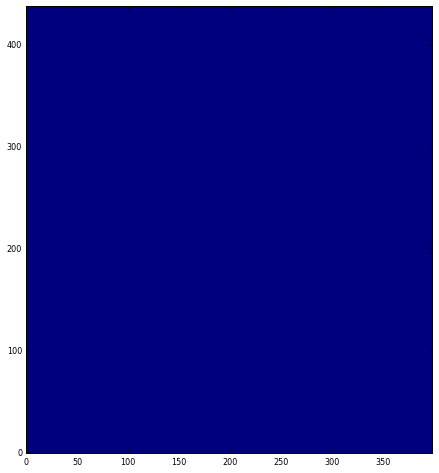

In [47]:
plt.imshow(ice_conc_rho)

<matplotlib.colorbar.Colorbar instance at 0x7f2540174dd0>

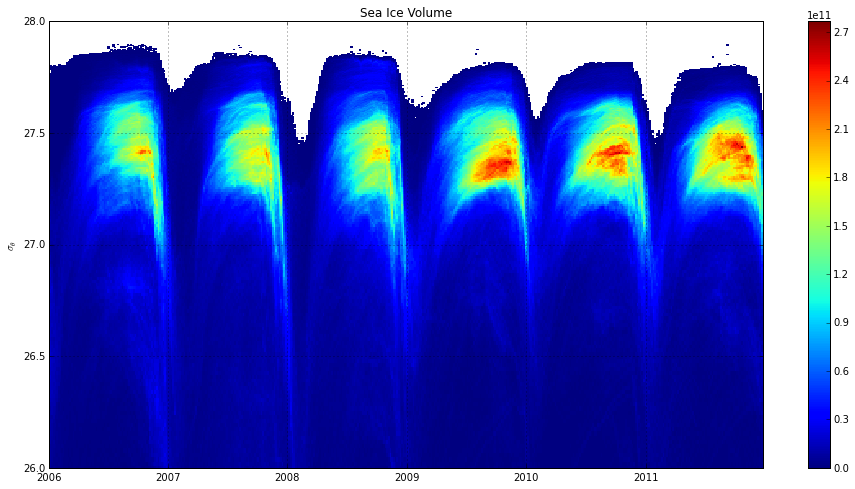

In [142]:
plt.pcolormesh(T, rl, np.ma.masked_array(heff_rho, outcrop_area<1e9).T, rasterized=True)
#plt.clim([-60,60])
plt.ylim([26,28])
plt.ylabel(r'$\sigma_\theta$')
plt.title('Sea Ice Volume')
plt.grid()
plt.colorbar()

In [92]:
m.rac.mean()/1e8

2.0704503627499999

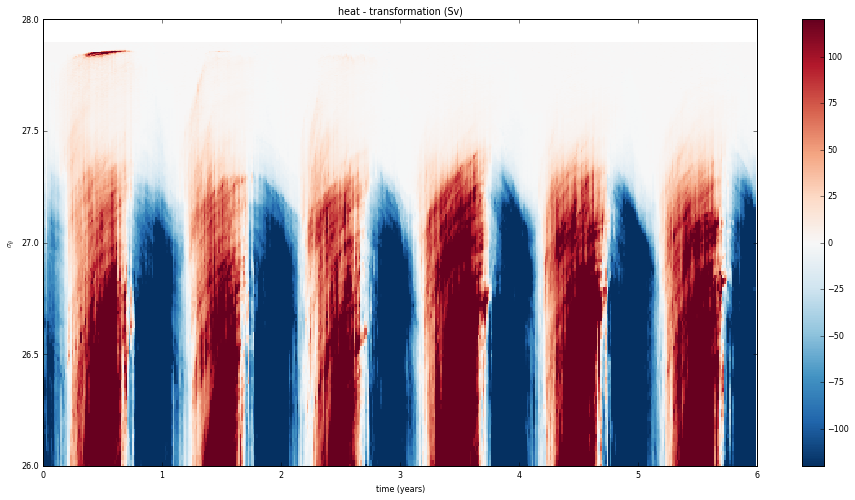

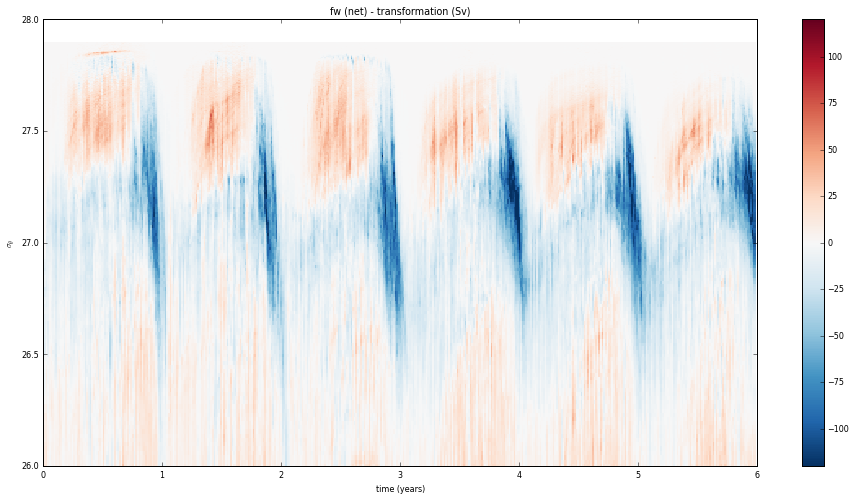

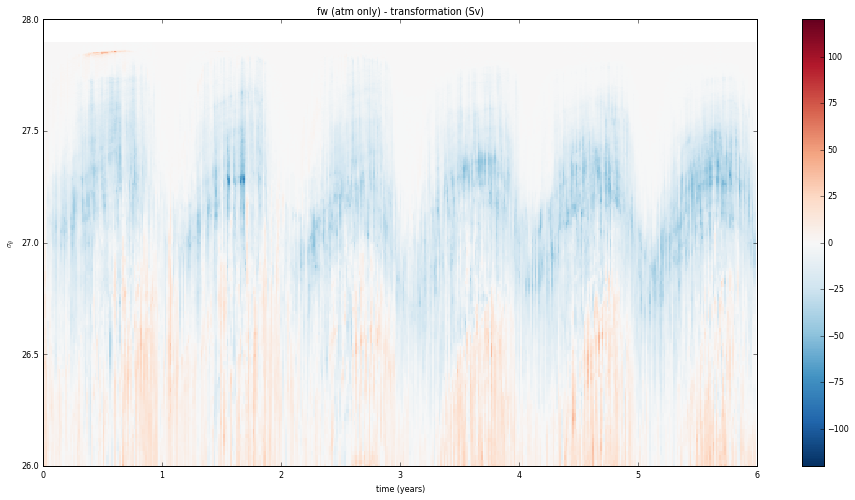

In [67]:
rl = rholevs[1:]-1000
time = np.arange(Nt)*5/365.

for n, tit in enumerate(['heat', 'fw (net)', 'fw (atm only)']):
    plt.figure()
    plt.pcolormesh(time, rl, transformation_monthy[:,n].T / 1e6, cmap='RdBu_r')
    plt.clim([-120,120])
    plt.ylim([26,28])
    plt.ylabel(r'$\sigma_\theta$')
    plt.xlabel('time (years)')
    plt.title(tit + ' - transformation (Sv)')
    plt.colorbar()